# 

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    RobertaTokenizerFast, RobertaForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    TrainerCallback, EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda")

In [3]:
# 📂 Load dataset
df = pd.read_csv("./dataset.csv")
df.columns = df.columns.str.strip()
df = df.iloc[1:]
df = df[df['Level'].isin([0, 1, 2, 3])]
df['Level'] = df['Level'].astype(int)
df.rename(columns={'Level': 'labels'}, inplace=True)

In [4]:
# 🧪 Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

# 📤 Convert to HF Datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

# 🔠 Tokenization
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

def tokenize_function(example):
    return tokenizer(example["Response"], truncation=True)

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)


Map:   0%|          | 0/4112 [00:00<?, ? examples/s]

Map:   0%|          | 0/1029 [00:00<?, ? examples/s]

In [5]:
# 📦 Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 🧠 Load RoBERTa model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# 📊 Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=-1).numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1,
    }

In [7]:
# 🧩 Accuracy logging callback
class AccuracyTrackerCallback(TrainerCallback):
    def __init__(self, trainer_ref):
        self.trainer = trainer_ref
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):
        train_output = self.trainer.predict(self.trainer.train_dataset)
        train_preds = train_output.predictions.argmax(axis=1)
        train_labels = train_output.label_ids
        train_acc = accuracy_score(train_labels, train_preds)
        self.train_accuracies.append(train_acc)

        eval_output = self.trainer.predict(self.trainer.eval_dataset)
        eval_preds = eval_output.predictions.argmax(axis=1)
        eval_labels = eval_output.label_ids
        eval_acc = accuracy_score(eval_labels, eval_preds)
        self.eval_accuracies.append(eval_acc)

        print(f"\n📊 Epoch {state.epoch:.0f} → Train Acc: {train_acc:.4f} | Val Acc: {eval_acc:.4f}")

In [8]:
# ⚙️ Training arguments
training_args = TrainingArguments(
    output_dir="./roberta_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_dir="./roberta_logs",
    logging_steps=50,
    save_total_limit=2
)

In [9]:
# 📦 Initialize trainer
accuracy_logger = AccuracyTrackerCallback(None)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        accuracy_logger,
        EarlyStoppingCallback(early_stopping_patience=7)
    ]
)

accuracy_logger.trainer = trainer

/tmp/ipykernel_26303/2637693720.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
import time
# Record start time
start_time = time.time()
# Run the training
trainer.train()
# Record end time
end_time = time.time()
# Calculate elapsed time
training_time = end_time - start_time
# Print training time
print(f"Training completed in {training_time:.2f} seconds")

Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,0.417800,0.399410,0.885326,0.897442,0.860114,0.870059
2,0.185500,0.328963,0.939747,0.939474,0.927350,0.931911
3,0.120100,0.326158,0.944606,0.939339,0.941210,0.938695
4,0.089500,0.357363,0.941691,0.945735,0.928771,0.935411
5,0.020200,0.329596,0.953353,0.953372,0.944369,0.948277
6,0.020600,0.446801,0.942663,0.948165,0.932360,0.938509
7,0.080500,0.464910,0.942663,0.940423,0.936174,0.935888
8,0.058400,0.279935,0.963071,0.960294,0.959933,0.959886
9,0.014000,0.368300,0.954325,0.955385,0.945800,0.950107
10,0.017900,0.356969,0.957240,0.956723,0.949123,0.952249



📊 Epoch 1 → Train Acc: 0.9246 | Val Acc: 0.8853

📊 Epoch 2 → Train Acc: 0.9754 | Val Acc: 0.9397

📊 Epoch 3 → Train Acc: 0.9908 | Val Acc: 0.9446

📊 Epoch 4 → Train Acc: 0.9908 | Val Acc: 0.9417

📊 Epoch 5 → Train Acc: 0.9973 | Val Acc: 0.9534

📊 Epoch 6 → Train Acc: 0.9912 | Val Acc: 0.9427

📊 Epoch 7 → Train Acc: 0.9959 | Val Acc: 0.9427

📊 Epoch 8 → Train Acc: 0.9998 | Val Acc: 0.9631

📊 Epoch 9 → Train Acc: 0.9990 | Val Acc: 0.9543

📊 Epoch 10 → Train Acc: 0.9990 | Val Acc: 0.9572

📊 Epoch 11 → Train Acc: 0.9981 | Val Acc: 0.9475

📊 Epoch 12 → Train Acc: 0.9998 | Val Acc: 0.9611

📊 Epoch 13 → Train Acc: 1.0000 | Val Acc: 0.9582

📊 Epoch 14 → Train Acc: 1.0000 | Val Acc: 0.9631

📊 Epoch 15 → Train Acc: 1.0000 | Val Acc: 0.9650

📊 Epoch 16 → Train Acc: 1.0000 | Val Acc: 0.9660

📊 Epoch 17 → Train Acc: 1.0000 | Val Acc: 0.9650

📊 Epoch 18 → Train Acc: 1.0000 | Val Acc: 0.9631

📊 Epoch 19 → Train Acc: 1.0000 | Val Acc: 0.9660

📊 Epoch 20 → Train Acc: 1.0000 | Val Acc: 0.9640
Training 

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,0.410000,0.303787,0.906706,0.908724,0.891245,0.895127
2,0.211700,0.255357,0.940719,0.944724,0.926918,0.932246
3,0.119800,0.306675,0.939747,0.932084,0.941808,0.935791
4,0.102800,0.291062,0.955296,0.957131,0.945745,0.950647
5,0.044800,0.274548,0.957240,0.954492,0.953289,0.953721
6,0.048000,0.253481,0.966958,0.968850,0.959903,0.963866
7,0.067900,0.278397,0.962099,0.957629,0.955993,0.956419
8,0.017000,0.291566,0.960155,0.957937,0.952711,0.954723
9,0.020000,0.268727,0.960155,0.956401,0.954602,0.955372
10,0.017400,0.265697,0.965015,0.965607,0.960173,0.962675



📊 Epoch 1 → Train Acc: 0.9377 | Val Acc: 0.9067

📊 Epoch 2 → Train Acc: 0.9764 | Val Acc: 0.9407

📊 Epoch 3 → Train Acc: 0.9893 | Val Acc: 0.9397

📊 Epoch 4 → Train Acc: 0.9961 | Val Acc: 0.9553

📊 Epoch 5 → Train Acc: 0.9978 | Val Acc: 0.9572

📊 Epoch 6 → Train Acc: 0.9966 | Val Acc: 0.9670

📊 Epoch 7 → Train Acc: 0.9998 | Val Acc: 0.9621

📊 Epoch 8 → Train Acc: 0.9995 | Val Acc: 0.9602

📊 Epoch 9 → Train Acc: 1.0000 | Val Acc: 0.9602

📊 Epoch 10 → Train Acc: 1.0000 | Val Acc: 0.9650

📊 Epoch 11 → Train Acc: 0.9995 | Val Acc: 0.9660

📊 Epoch 12 → Train Acc: 0.9998 | Val Acc: 0.9708

📊 Epoch 13 → Train Acc: 1.0000 | Val Acc: 0.9689

📊 Epoch 14 → Train Acc: 0.9998 | Val Acc: 0.9582

📊 Epoch 15 → Train Acc: 0.9998 | Val Acc: 0.9621

📊 Epoch 16 → Train Acc: 1.0000 | Val Acc: 0.9679

📊 Epoch 17 → Train Acc: 1.0000 | Val Acc: 0.9640

📊 Epoch 18 → Train Acc: 1.0000 | Val Acc: 0.9640

📊 Epoch 19 → Train Acc: 1.0000 | Val Acc: 0.9708


TrainOutput(global_step=9766, training_loss=0.0625632012100208, metrics={'train_runtime': 10234.7021, 'train_samples_per_second': 8.035, 'train_steps_per_second': 1.004, 'total_flos': 993442961961216.0, 'train_loss': 0.0625632012100208, 'epoch': 19.0})

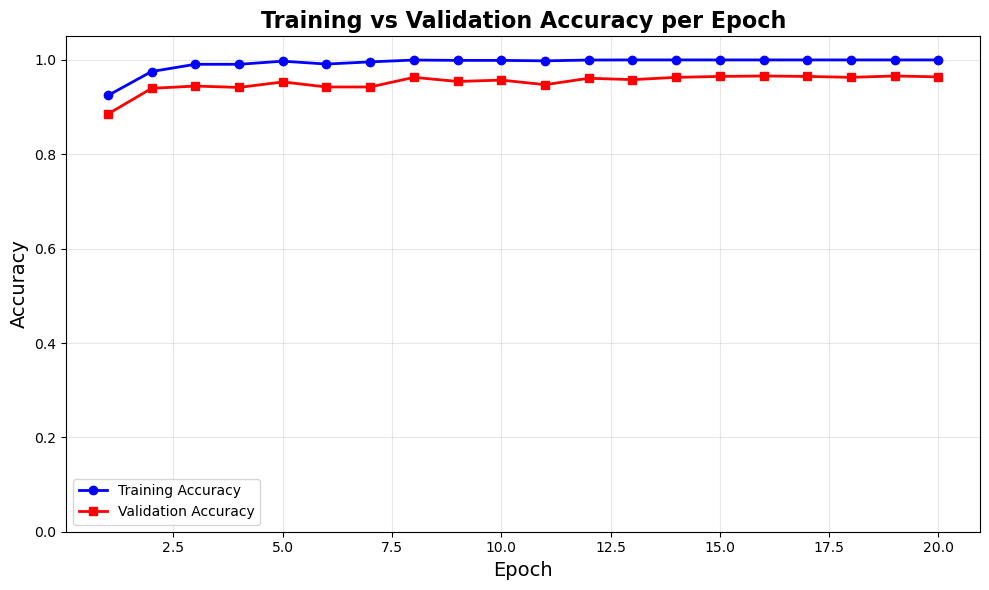

In [11]:
# 📈 Plot Training vs Validation Accuracy
train_accs = accuracy_logger.train_accuracies
val_accs = accuracy_logger.eval_accuracies
epochs = range(1, len(train_accs) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accs, label="Training Accuracy", marker='o', linewidth=2, color='blue')
plt.plot(epochs, val_accs, label="Validation Accuracy", marker='s', linewidth=2, color='red')

plt.title("Training vs Validation Accuracy per Epoch", fontsize=16, fontweight='bold')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# 🔍 Final Evaluation
preds = trainer.predict(test_ds)
y_pred = preds.predictions.argmax(axis=1)
y_true = preds.label_ids

print("\n🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Level 0", "Level 1", "Level 2", "Level 3"], digits=4))
print(f"\n📊 Final Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")



🔍 Classification Report:

              precision    recall  f1-score   support

     Level 0     0.9577    0.9942    0.9756       342
     Level 1     0.9747    0.9234    0.9484       209
     Level 2     0.9781    0.9179    0.9471       195
     Level 3     0.9625    0.9965    0.9792       283

    accuracy                         0.9660      1029
   macro avg     0.9683    0.9580    0.9626      1029
weighted avg     0.9664    0.9660    0.9657      1029


📊 Final Test Accuracy: 0.9660


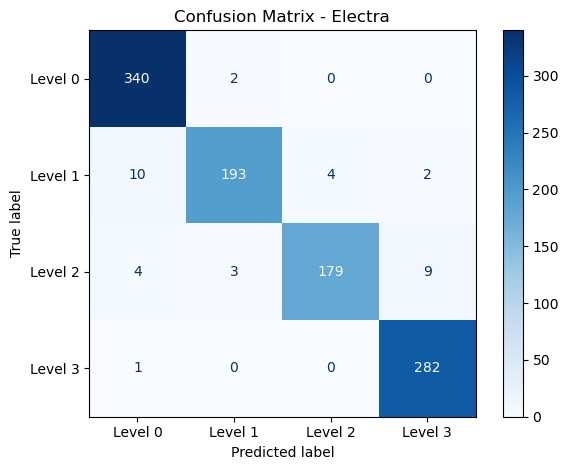

In [13]:
# 📉 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Level 0", "Level 1", "Level 2", "Level 3"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Electra")
plt.tight_layout()
plt.show()

In [14]:
trainer.save_model("./roberta_saved")
tokenizer.save_pretrained("./roberta_saved")

('./roberta_saved/tokenizer_config.json',
 './roberta_saved/special_tokens_map.json',
 './roberta_saved/vocab.json',
 './roberta_saved/merges.txt',
 './roberta_saved/added_tokens.json',
 './roberta_saved/tokenizer.json')